In [1]:
from pygam import GAM, s, te
from pygam import LogisticGAM, s, f, l
from pygam.datasets import default
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
rs = np.random.RandomState(0)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 6
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

NUM_BINS = 10
N = 10000 # takes value from 1 to 10000
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 2
METHOD_NAME = "binary_spline"

try out the PyGAM package (e.g., Logistic GAM with splines) for one or more of our datasets (e.g., p(y=1 | max_k s_k(x)) for calibration, or Accuracy( g (x) ) versus g(x) where g(x) is brightness - to get a sense whether this approach is a bit more robust than (say) GP classification methods.

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("data/cifar100_predictions_dropout.txt")[0:N,:]# 10000*101
p = data[:,1:]
Y_predict = np.argmax(p, axis=1)
Y_true = data[:,0]

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def spline_classification(ax, X, y):
    #gam = LogisticGAM(s(0)).gridsearch(X, y)
    # documentation of LogisticGAM: https://pygam.readthedocs.io/en/latest/api/logisticgam.html
    gam = LogisticGAM(s(0, constraints='monotonic_inc')).gridsearch(X, y) # add a linear term
    XX = gam.generate_X_grid(term=0)
    pdep, confi = gam.partial_dependence(term=0, width=.95)
    ax.plot(XX[:, 0], sigmoid(pdep))
    ax.plot(XX[:, 0], sigmoid(confi), c='r', ls='--')
    print gam.accuracy(X, y)
    print gam.summary()
    return ax

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


0.8052
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      14.854
Link Function:                        LogitLink Log Likelihood:                                 -3914.0937
Number of Samples:                        10000 AIC:                                             7857.8954
                                                AICc:                                            7857.9489
                                                UBRE:                                                2.787
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3152
Feature Function              

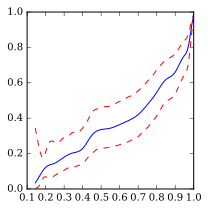

In [8]:
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ax = spline_classification(ax,
                           np.max(p, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1)
fig.tight_layout()

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

0.998
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      5.5132
Link Function:                        LogitLink Log Likelihood:                                   -75.7192
Number of Samples:                        10000 AIC:                                              162.4648
                                                AICc:                                             162.4746
                                                UBRE:                                               2.0167
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8648
Feature Function               

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

0.9975
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      6.3801
Link Function:                        LogitLink Log Likelihood:                                   -82.7214
Number of Samples:                        10000 AIC:                                               178.203
                                                AICc:                                             178.2154
                                                UBRE:                                               2.0183
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8523
Feature Function              

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

0.994
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      6.2908
Link Function:                        LogitLink Log Likelihood:                                  -189.6374
Number of Samples:                        10000 AIC:                                              391.8564
                                                AICc:                                             391.8685
                                                UBRE:                                               2.0397
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6614
Feature Function               

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


0.9936
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      8.9266
Link Function:                        LogitLink Log Likelihood:                                  -204.1972
Number of Samples:                        10000 AIC:                                              426.2476
                                                AICc:                                             426.2693
                                                UBRE:                                               2.0433
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6354
Feature Function              

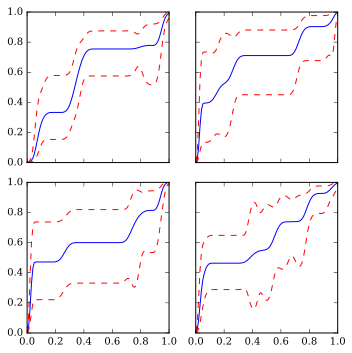

In [9]:
fig, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
fig.set_figheight(5)
fig.set_figwidth(5)
for K in range(NUM_CLASSES_PLOT):
    ax[K/NUM_COL, K%NUM_COL] = spline_classification(ax[K/NUM_COL, K%NUM_COL],
                                             p[:,K:K+1],
                                             np.array((Y_true == K)) * 1)
fig.tight_layout()
#f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
#f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
#plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')